# README

The goal of this project is to develop and train a long-short term memory neural network to detect toxic internet comments.

The dataset used in this task was taken from the Toxic Comment Classification Challenge by Jigsaw.

To achieve the goal, the following steps were taken:
1. General preprocessing:

    a. Generalizing the data for binary classification task
    
    b. Data visualization
    
2. Preprocessing for LSTM:

    a. Removing stop words

    b. Lemmatization

    c. Tokenization

    d. Vocabulary creation

3. Building an LSTM model with Pytorch

The project is still in progress, and the full results are yet to be seen.

Warning: Due to working with explicit data, the project contains elements that some may find offensive and obscene.

# 00 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import spacy

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# 01 General preprocessing

In [4]:
data = pd.read_csv('raw_data/raw_data.csv')
data.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
102067,224232231ae84239,"""\nThe Slashdot Article has a section on """"Art...",0,0,0,0,0,0
141748,f65f60f874161f54,Please stop being smug and supply me with a re...,1,0,0,0,0,0
98720,101754e174ab5058,AfD humor \n\nYou might like File:Lolcat2.jpg ...,0,0,0,0,0,0


In [3]:
# Generalization for binary classification task

data['label'] = (data.iloc[:, :-1] == 1).any(axis=1).astype(int)

data.drop(columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat',
                   'insult', 'identity_hate'], inplace=True)

data.sample(5)

,comment_text,label
47543,"Piss off \n\nHomo, no one wants to hear from y...",1
103917,"Talkback\n\nBTW, Otopeni is now Henri Coandă I...",0
102689,The Real IRA was designated a terrorist organi...,0
50374,"""""""Just because other stuff doesn't make it wr...",0
100431,"""grandson not """"Tenzin Yeshe Dorje Rinpoche""""""",0


In [4]:
data.shape

(159571, 2)

In [5]:
data[data['label'] == 1].sample(3)['comment_text']

25666    Total Asshole bitches like you just need to ge...
94184    Who the hell do you think you are?? \n\nYou th...
2089     Knock it off! \n\nSpinningSpark, quit it! You'...
Name: comment_text, dtype: object

In [6]:
# Checking for dulpicates

data['comment_text'].duplicated().sum()

0

In [7]:
data['comment_text'].dtype

dtype('O')

C:\Users\rados\AppData\Local\Temp\ipykernel_7904\2459196326.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


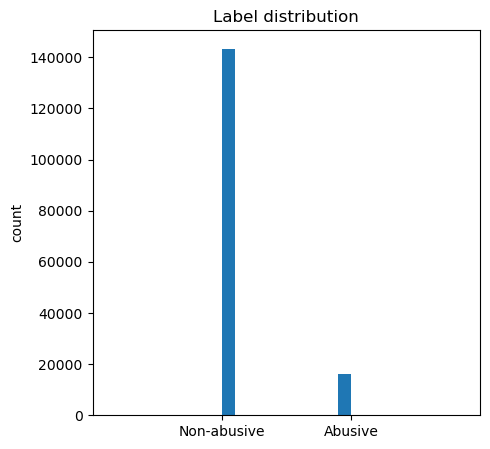

In [8]:
# Distribution of labels

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(data['label'])
ax.set_ylabel('count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-abusive', 'Abusive'])
ax.set_xlim([-1, 2])
ax.set_title('Label distribution')
fig.show()

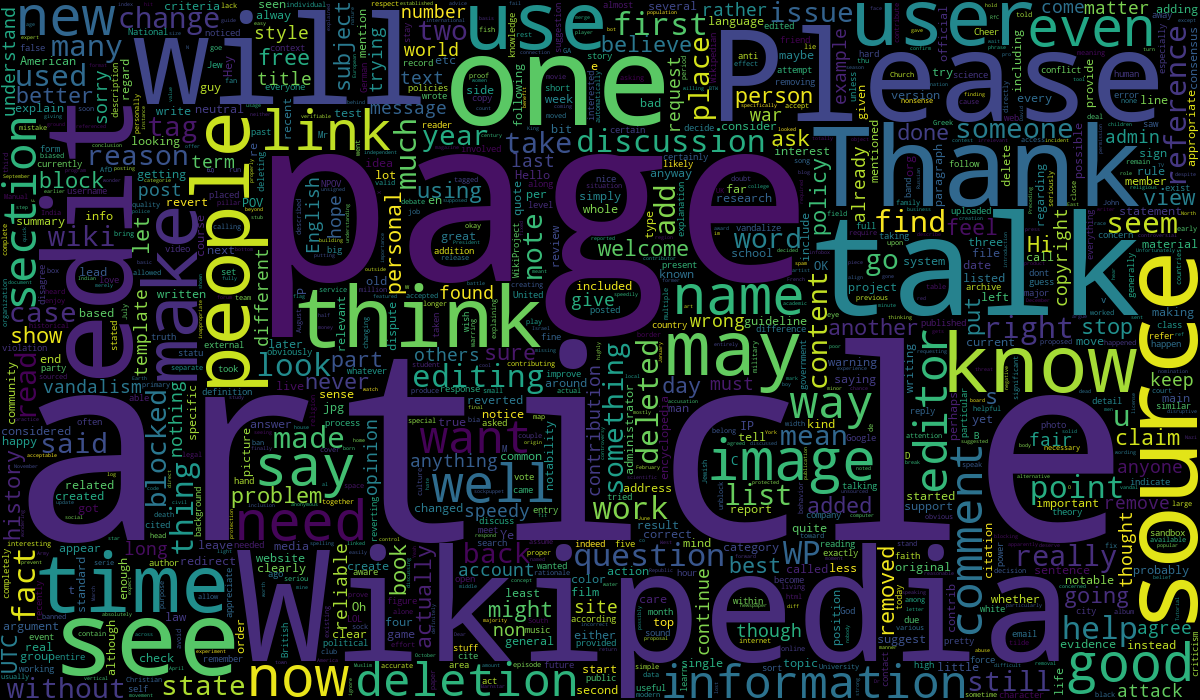

In [9]:
# Word Clouds

text_nonabusive = ' '.join(data[data['label']==0]['comment_text'])

wc_nonabusive = WordCloud(max_words=1000, width=1200,
                   height=700, collocations=False).generate(text_nonabusive)
wc_nonabusive.to_image()

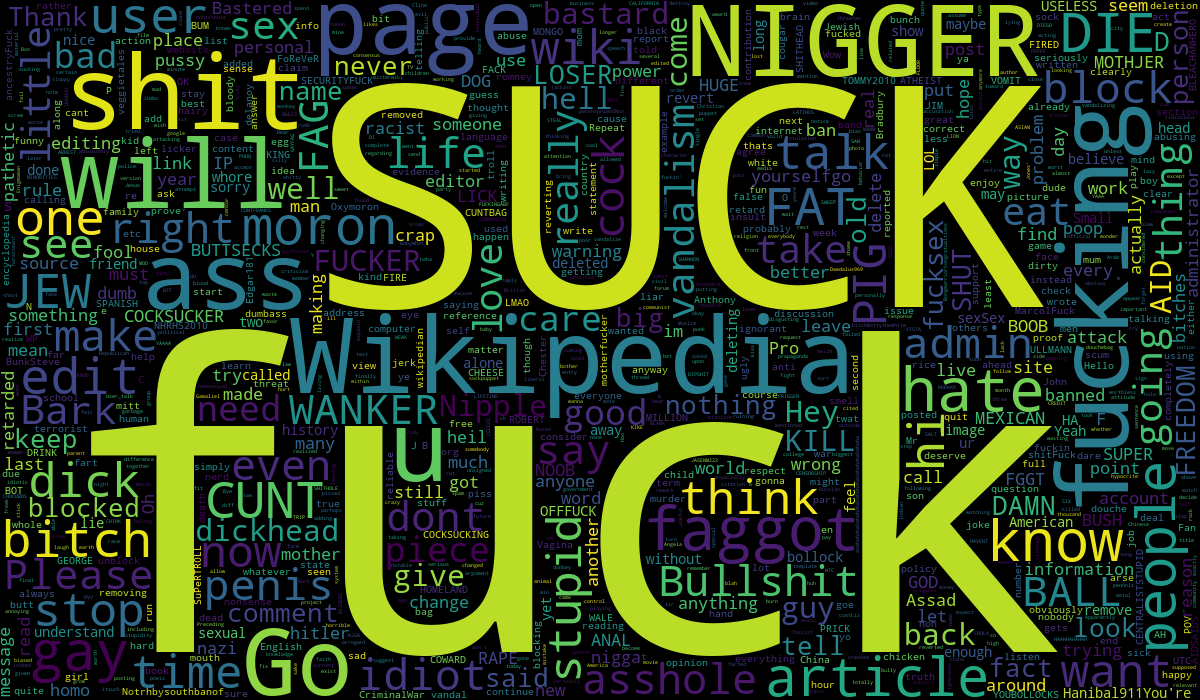

In [10]:
text_abusive = ' '.join(data[data['label']==1]['comment_text'])

wc_abusive = WordCloud(max_words=1000, width=1200,
                   height=700, collocations=False).generate(text_abusive)
wc_abusive.to_image()

# 02 LSTM

In [11]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])

In [12]:
# Removing stopwords

def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['comment_text'] = data['comment_text'].apply(remove_stopwords)

In [5]:
# Lemmatizing

# def lemmatize(text):
#   return ' '.join([x.lemma_ for x in nlp(text)])

# data['comment_text'] = data['comment_text'].apply(lemmatize)
# data.to_csv('preprocessed_data/lemmatized.csv')

data = pd.read_csv('preprocessed_data/lemmatized.csv', index_col=0)

In [14]:
data.sample(5)

,comment_text,label
4622,""" you be funny cat Iron Duke . I be stoke anyt...",0
30108,""" the term "" "" Bathroom "" "" basically apply ro...",0
100445,""" block I currently block 24 hour . any questi...",0
131061,|HAHA ! a string racist religious attack ? wha...,0
95781,merge ? qatarson create Denmark boycott poor t...,0


In [15]:
# Splitting data

train_size=0.9
val_size=0.2

X_train, X_test, y_train, y_test = train_test_split(
    data['comment_text'], data['label'], train_size=train_size,
    stratify=data['label'], random_state=12)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(val_size / train_size),
    stratify=y_train, random_state=42)


In [16]:
# Token generator

tokenizer = get_tokenizer('spacy', 'en_core_web_md')

def yield_tokens(iter):
  for text in iter:
    yield tokenizer(str(text).lower())

# Creating vocabulary

MAX_TOKENS = 50000

vocab = build_vocab_from_iterator(
    yield_tokens(X_train),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [17]:
vocab(['I', 'like', 'trains'])

[0, 23, 0]

In [18]:
# Preparing dataloaders

text_pipeline = lambda x: vocab(tokenizer(str(x)))
# label_pipeline = lambda x: 1 if x == 1 else 0

def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []

  for _text, _label in batch:
    label_list.append(_label)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  labels = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  texts = pad_sequence(text_list, batch_first=True)
  return texts, labels, lenghts

BATCH_SIZE = 64
train_dataloader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(list(zip(X_val, y_val)), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [19]:
for i, X in enumerate(train_dataloader):
    print(X)
    if i == 3:
        break

(tensor([[ 337,    0,    2,  ...,    0,    0,    0],
        [   3,   25,    3,  ...,    0,    0,    0],
        [6560,  598,  247,  ...,    0,    0,    0],
        ...,
        [  17,   12,   68,  ...,    0,    0,    0],
        [   3,    0,  863,  ...,    0,    0,    0],
        [   3,    0,    0,  ...,    0,    0,    0]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 

In [20]:
# Creating a model

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers):

        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):

        embedded = self.embedding(x)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        last_output = output[torch.arange(output.size(0)), lengths - 1, :]

        fc_output = self.fc(last_output)

        output_probabilities = self.sigmoid(fc_output)

        return output_probabilities

In [ ]:
# Initializing and training

embedding_dim = 100
hidden_size = 50
output_size = 1
num_layers = 2

lstm = LSTM(MAX_TOKENS, embedding_dim, hidden_size, output_size, num_layers)

criterion = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    for i, (texts, labels, lengths) in enumerate(train_dataloader):
        lstm.train()
        optimizer.zero_grad()
        outputs = lstm(texts, lengths)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        lstm.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for val_inputs, val_labels, val_lengths in val_dataloader:

                val_outputs = lstm(val_inputs, val_lengths)
                val_loss += criterion(val_outputs.squeeze(), val_labels).item()

                predicted = (val_outputs > 0.5).float()
                correct += (predicted == val_labels).sum().item()
                total += val_labels.size(0)

        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Validation Loss: {avg_val_loss:.4f}')